# EfficientNet Model Training

This notebook contains model training process for EfficientNet model on three different deepfake detection datasets. The model training splitted into two parts, which are baseline model (base model without dropout) and the dropout model itself.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7, efficientnet
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pickle
import os

## Define Dataset Directory

In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC"

In [3]:
cdf_train_dir = os.path.join(CDF_DATASET_DIR, "Train")
cdf_val_dir = os.path.join(CDF_DATASET_DIR, "Val")

df_train_dir = os.path.join(DF_DATASET_DIR, "Train")
df_val_dir = os.path.join(DF_DATASET_DIR, "Val")

dfdc_train_dir = os.path.join(DFDC_DATASET_DIR, "Train")
dfdc_val_dir = os.path.join(DFDC_DATASET_DIR, "Val")

## Image Data Generator for Each Dataset

In [4]:
def create_image_generator(dataset_dir):
    datagen = ImageDataGenerator(preprocessing_function=efficientnet.preprocess_input)
    image_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode="rgb",
        class_mode="binary",
        shuffle=True,
        seed=42
    )

    return image_generator

In [5]:
print("Celeb-DF-v2 Dataset")
cdf_train_generator = create_image_generator(cdf_train_dir)
cdf_val_generator = create_image_generator(cdf_val_dir)

print("\nDeeperForensics-1.0 Dataset")
df_train_generator = create_image_generator(df_train_dir)
df_val_generator = create_image_generator(df_val_dir)

print("\nDeepfake Detection Challenge Dataset")
dfdc_train_generator = create_image_generator(dfdc_train_dir)
dfdc_val_generator = create_image_generator(dfdc_val_dir)

Celeb-DF-v2 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

DeeperForensics-1.0 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Deepfake Detection Challenge Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Get the Best Hyperparameters from Tuner

In [6]:
TUNER_RESULT_DIR = "/kaggle/input/hp-tuning/tuner-result"
TUNER_PROJECT_NAME = "cnn-best-hp"

In [7]:
tuner = kt.Hyperband(directory=TUNER_RESULT_DIR,
                     project_name=TUNER_PROJECT_NAME,
                     objective="val_accuracy",
                     overwrite=False)

Reloading Tuner from /kaggle/input/hp-tuning/tuner-result/cnn-best-hp/tuner0.json


In [8]:
best_hp = tuner.get_best_hyperparameters()[0].values
best_hp

{'conv_layers': 6,
 'conv_1_filters': 256,
 'conv_2_filters': 32,
 'conv_3_filters': 160,
 'conv_1_kernel_size': 3,
 'conv_2_kernel_size': 5,
 'conv_3_kernel_size': 5,
 'dense_layers': 6,
 'dense_1_layer_units': 128,
 'dense_2_layer_units': 96,
 'dropout_rate': 0.6000000000000001,
 'learning_rate': 1e-05,
 'dense_3_layer_units': 96,
 'dense_4_layer_units': 96,
 'dense_5_layer_units': 64,
 'conv_4_filters': 128,
 'conv_4_kernel_size': 5,
 'conv_5_filters': 192,
 'conv_6_filters': 128,
 'conv_7_filters': 224,
 'conv_5_kernel_size': 5,
 'conv_6_kernel_size': 5,
 'conv_7_kernel_size': 3,
 'dense_6_layer_units': 128,
 'dense_7_layer_units': 32,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0023'}

## Function to Create an EfficientNet Model

In [9]:
def create_efficientnet_model(hp, dropout=False, name="efficientnet_model"):
    base_model = EfficientNetB7(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.Sequential(name=name)
    model.add(tf.keras.layers.Input(shape=(128, 128, 3)))
    model.add(base_model)
    model.add(tf.keras.layers.Flatten(name="flatten"))

    for i in range(hp.get("dense_layers")):
        dense_units = hp.get(f"dense_{i+1}_layer_units")
        model.add(
            tf.keras.layers.Dense(dense_units, activation="relu", name=f"dense_{i+1}")
        )

    if dropout:
        model.add(tf.keras.layers.Dropout(hp.get("dropout_rate"), name="dropout"))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get("learning_rate")),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )

    return model

## Function to Plot Train Results

In [10]:
def plot_train_result(history, title="Training Result"):
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Function to Save Model Training History

In [11]:
def save_model_and_history(model, history, model_name):
    model_filename = f"{model_name}_model.keras"
    history_filename = f"{model_name}_history.pkl"

    model.save(model_filename)
    print(f"Model saved at {model_filename}")    

    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
        print(f"Training history saved at {history_filename}")

## Model Training

In [12]:
NUM_EPOCHS = 10

### Baseline EfficientNet

#### Celeb-DF-v2 Dataset

In [13]:
baseline_efficientnet_cdf_model = create_efficientnet_model(best_hp, name="baseline_efficientnet_cdf_model")
baseline_efficientnet_cdf_model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "baseline_efficientnet_cdf_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 4, 4, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,386,360 (264.69 MB)

 Trainable params: 5,288,673 (20.17 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [14]:
baseline_efficientnet_cdf_history = baseline_efficientnet_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731560603.924087     106 service.cc:145] XLA service 0x57dbd7613ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731560603.924151     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/438 ━━━━━━━━━━━━━━━━━━━━ 17:34:20 145s/step - accuracy: 0.4688 - loss: 0.7160

I0000 00:00:1731560706.798659     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 367s 508ms/step - accuracy: 0.5816 - loss: 0.6709 - val_accuracy: 0.5815 - val_loss: 0.6840
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.7252 - loss: 0.5583 - val_accuracy: 0.5960 - val_loss: 0.7196
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.7975 - loss: 0.4594 - val_accuracy: 0.6120 - val_loss: 0.8326
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.8514 - loss: 0.3687 - val_accuracy: 0.6085 - val_loss: 0.9522
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.8655 - loss: 0.3332 - val_accuracy: 0.6080 - val_loss: 0.9920
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.8899 - loss: 0.2824 - val_accuracy: 0.6200 - val_loss: 1.0443
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9135 - loss: 0.2362 - val_accuracy: 0.6060 - val_loss: 1.1132
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9190 - loss: 0.2138 - val_accur

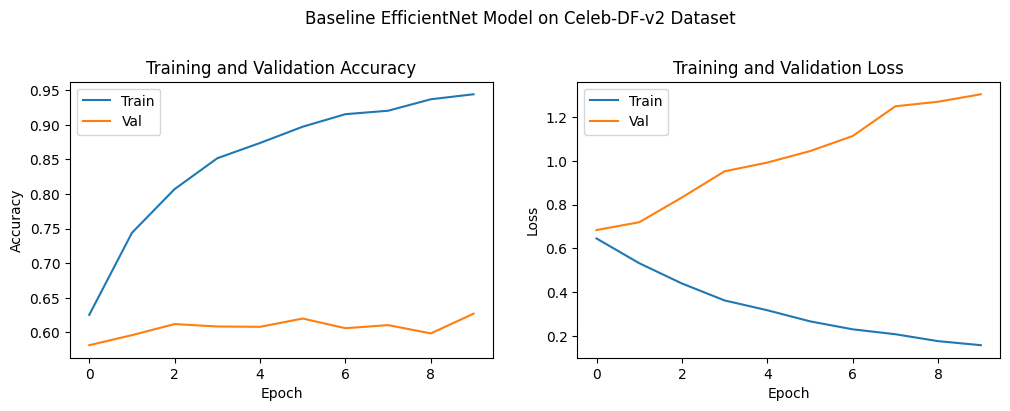

In [15]:
plot_train_result(
    baseline_efficientnet_cdf_history.history,
    title="Baseline EfficientNet Model on Celeb-DF-v2 Dataset"
)

In [16]:
save_model_and_history(
    baseline_efficientnet_cdf_model, baseline_efficientnet_cdf_history, "baseline_efficientnet_cdf"
)

Model saved at baseline_efficientnet_cdf_model.keras
Training history saved at baseline_efficientnet_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [17]:
baseline_efficientnet_df_model = create_efficientnet_model(best_hp, name="baseline_efficientnet_df_model")
baseline_efficientnet_df_model.summary()

Model: "baseline_efficientnet_df_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 4, 4, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,386,360 (264.69 MB)

 Trainable params: 5,288,673 (20.17 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [18]:
baseline_efficientnet_df_history = baseline_efficientnet_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 357s 514ms/step - accuracy: 0.7344 - loss: 0.5357 - val_accuracy: 0.7755 - val_loss: 0.4599
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9568 - loss: 0.1587 - val_accuracy: 0.8235 - val_loss: 0.4329
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9795 - loss: 0.0780 - val_accuracy: 0.8225 - val_loss: 0.4331
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.9872 - loss: 0.0494 - val_accuracy: 0.8105 - val_loss: 0.5001
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9908 - loss: 0.0353 - val_accuracy: 0.8110 - val_loss: 0.5402
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9907 - loss: 0.0299 - val_accuracy: 0.8380 - val_loss: 0.4433
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9931 - loss: 0.0228 - val_accuracy: 0.8355 - val_loss: 0.4605
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9958 - loss: 0.0179 

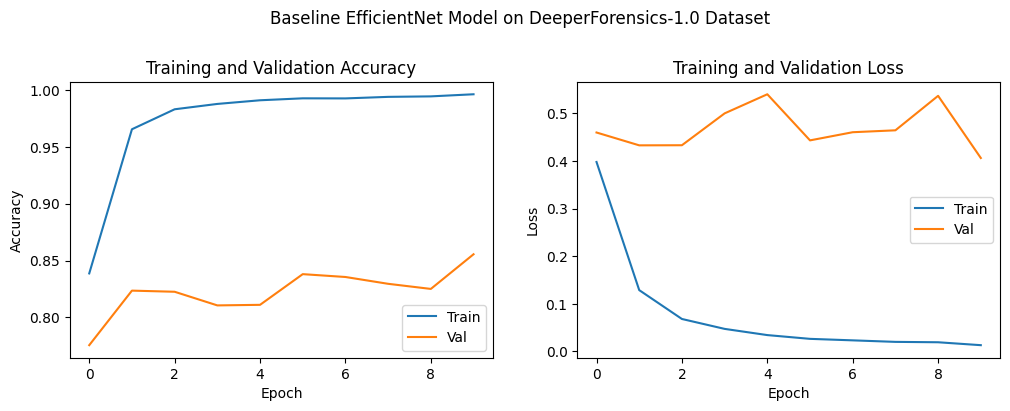

In [19]:
plot_train_result(
    baseline_efficientnet_df_history.history,
    title="Baseline EfficientNet Model on DeeperForensics-1.0 Dataset"
)

In [20]:
save_model_and_history(
    baseline_efficientnet_df_model, baseline_efficientnet_df_history, "baseline_efficientnet_df"
)

Model saved at baseline_efficientnet_df_model.keras
Training history saved at baseline_efficientnet_df_history.pkl


#### DFDC Dataset

In [21]:
baseline_efficientnet_dfdc_model = create_efficientnet_model(best_hp, name="baseline_efficientnet_dfdc_model")
baseline_efficientnet_dfdc_model.summary()

Model: "baseline_efficientnet_dfdc_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 4, 4, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,386,360 (264.69 MB)

 Trainable params: 5,288,673 (20.17 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [22]:
baseline_efficientnet_dfdc_history = baseline_efficientnet_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 367s 529ms/step - accuracy: 0.5789 - loss: 0.6772 - val_accuracy: 0.5870 - val_loss: 0.6949
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.7684 - loss: 0.5239 - val_accuracy: 0.5915 - val_loss: 0.7545
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.8671 - loss: 0.3569 - val_accuracy: 0.5850 - val_loss: 0.8742
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9015 - loss: 0.2710 - val_accuracy: 0.5840 - val_loss: 1.0907
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9297 - loss: 0.2068 - val_accuracy: 0.5830 - val_loss: 1.0727
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.9395 - loss: 0.1749 - val_accuracy: 0.5860 - val_loss: 1.2669
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.9479 - loss: 0.1511 - val_accuracy: 0.5630 - val_loss: 1.3208
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.9520 - loss: 0.1332 

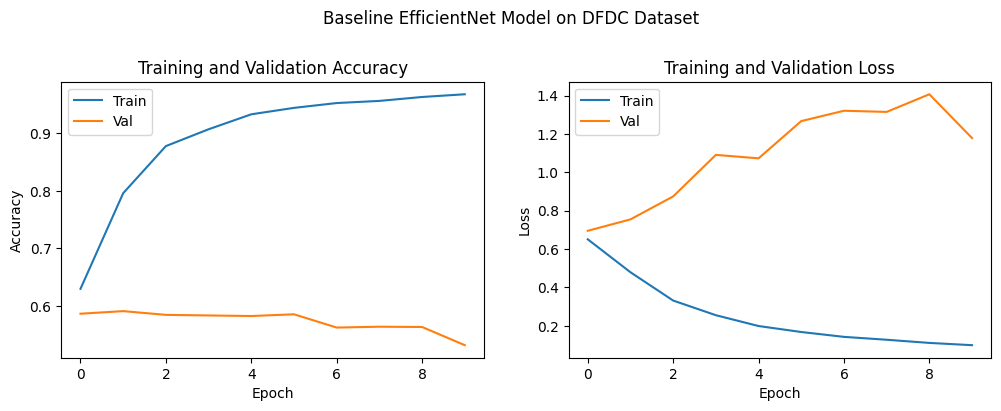

In [23]:
plot_train_result(
    baseline_efficientnet_dfdc_history.history,
    title="Baseline EfficientNet Model on DFDC Dataset"
)

In [24]:
save_model_and_history(
    baseline_efficientnet_dfdc_model, baseline_efficientnet_dfdc_history, "baseline_efficientnet_dfdc"
)

Model saved at baseline_efficientnet_dfdc_model.keras
Training history saved at baseline_efficientnet_dfdc_history.pkl


### Dropout EfficientNet Model Training

#### Celeb-DF-v2 Dataset

In [25]:
dropout_efficientnet_cdf_model = create_efficientnet_model(best_hp, dropout=True, name="dropout_efficientnet_cdf_model")
dropout_efficientnet_cdf_model.summary()

Model: "dropout_efficientnet_cdf_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 4, 4, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,386,360 (264.69 MB)

 Trainable params: 5,288,673 (20.17 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [26]:
dropout_efficientnet_cdf_history = dropout_efficientnet_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 293s 352ms/step - accuracy: 0.5184 - loss: 0.6922 - val_accuracy: 0.5770 - val_loss: 0.6819
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.6190 - loss: 0.6554 - val_accuracy: 0.6050 - val_loss: 0.6570
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.7033 - loss: 0.5882 - val_accuracy: 0.6085 - val_loss: 0.6719
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.7587 - loss: 0.5213 - val_accuracy: 0.6155 - val_loss: 0.7106
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.8040 - loss: 0.4500 - val_accuracy: 0.5850 - val_loss: 0.7972
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.8362 - loss: 0.3928 - val_accuracy: 0.6260 - val_loss: 0.7875
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.8605 - loss: 0.3488 - val_accuracy: 0.6200 - val_loss: 0.9177
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.8740 - loss: 0.3103 

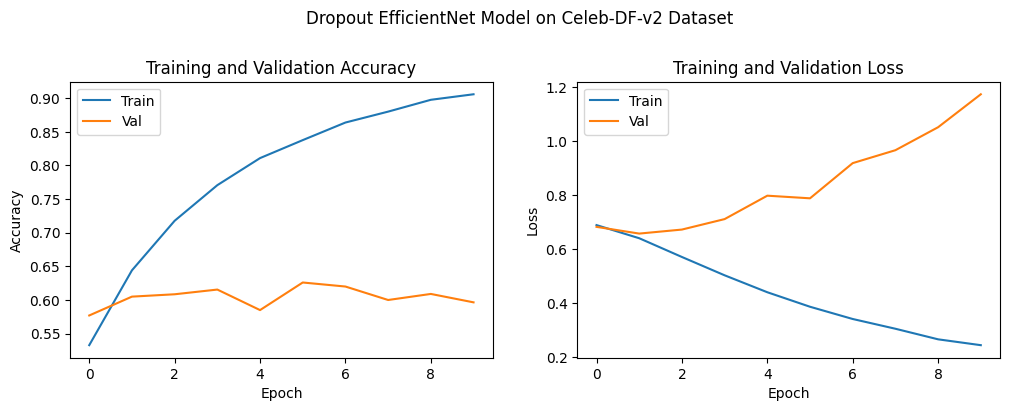

In [27]:
plot_train_result(
    dropout_efficientnet_cdf_history.history,
    title="Dropout EfficientNet Model on Celeb-DF-v2 Dataset"
)

In [28]:
save_model_and_history(
    dropout_efficientnet_cdf_model, dropout_efficientnet_cdf_history, "dropout_efficientnet_cdf"
)

Model saved at dropout_efficientnet_cdf_model.keras
Training history saved at dropout_efficientnet_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [29]:
dropout_efficientnet_df_model = create_efficientnet_model(best_hp, dropout=True, name="dropout_efficientnet_df_model")
dropout_efficientnet_df_model.summary()

Model: "dropout_efficientnet_df_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 4, 4, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,386,360 (264.69 MB)

 Trainable params: 5,288,673 (20.17 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [30]:
dropout_efficientnet_df_history = dropout_efficientnet_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 316s 378ms/step - accuracy: 0.6372 - loss: 0.6285 - val_accuracy: 0.7915 - val_loss: 0.4732
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9081 - loss: 0.2891 - val_accuracy: 0.8410 - val_loss: 0.3938
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9596 - loss: 0.1440 - val_accuracy: 0.7960 - val_loss: 0.4858
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9765 - loss: 0.0910 - val_accuracy: 0.8000 - val_loss: 0.5036
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9808 - loss: 0.0696 - val_accuracy: 0.8550 - val_loss: 0.3789
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9863 - loss: 0.0520 - val_accuracy: 0.8215 - val_loss: 0.5013
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.9910 - loss: 0.0372 - val_accuracy: 0.8115 - val_loss: 0.5661
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.9862 - loss: 0.0412 

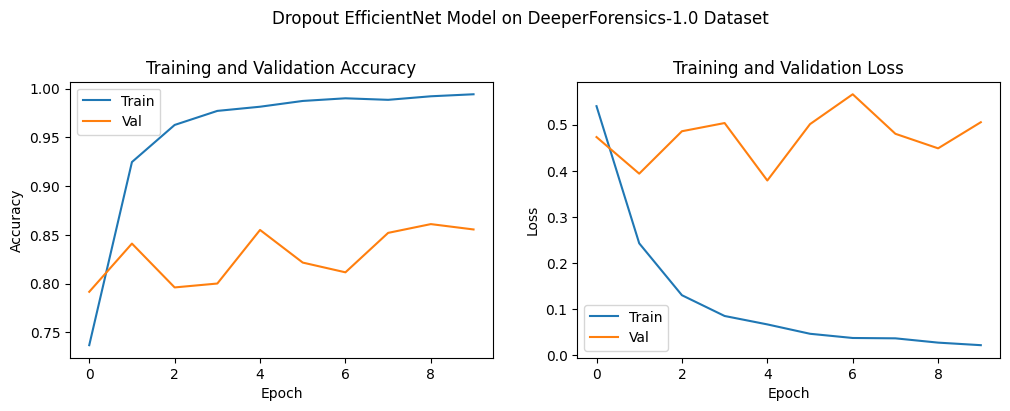

In [31]:
plot_train_result(
    dropout_efficientnet_df_history.history,
    title="Dropout EfficientNet Model on DeeperForensics-1.0 Dataset"
)

In [32]:
save_model_and_history(
    dropout_efficientnet_df_model, dropout_efficientnet_df_history, "dropout_efficientnet_df"
)

Model saved at dropout_efficientnet_df_model.keras
Training history saved at dropout_efficientnet_df_history.pkl


#### DFDC Dataset

In [33]:
dropout_efficientnet_dfdc_model = create_efficientnet_model(best_hp, dropout=True, name="dropout_efficientnet_dfdc_model")
dropout_efficientnet_dfdc_model.summary()

Model: "dropout_efficientnet_dfdc_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 4, 4, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,386,360 (264.69 MB)

 Trainable params: 5,288,673 (20.17 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [34]:
dropout_efficientnet_dfdc_history = dropout_efficientnet_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 309s 380ms/step - accuracy: 0.5369 - loss: 0.6877 - val_accuracy: 0.6140 - val_loss: 0.6793
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.7076 - loss: 0.5917 - val_accuracy: 0.5245 - val_loss: 0.7055
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.8106 - loss: 0.4475 - val_accuracy: 0.6040 - val_loss: 0.8062
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.8786 - loss: 0.3266 - val_accuracy: 0.5900 - val_loss: 0.8237
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9077 - loss: 0.2545 - val_accuracy: 0.5720 - val_loss: 0.9996
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9229 - loss: 0.2054 - val_accuracy: 0.5665 - val_loss: 1.1658
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9371 - loss: 0.1785 - val_accuracy: 0.5590 - val_loss: 1.0986
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.9513 - loss: 0.1430 

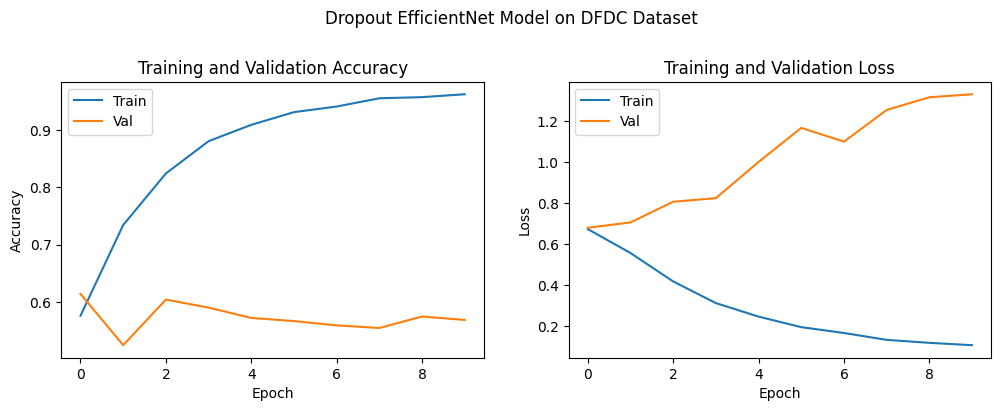

In [35]:
plot_train_result(
    dropout_efficientnet_dfdc_history.history,
    title="Dropout EfficientNet Model on DFDC Dataset"
)

In [36]:
save_model_and_history(
    dropout_efficientnet_dfdc_model, dropout_efficientnet_dfdc_history, "dropout_efficientnet_dfdc"
)

Model saved at dropout_efficientnet_dfdc_model.keras
Training history saved at dropout_efficientnet_dfdc_history.pkl
